<center>

# Handling GODAS Data For Animation
## San Diego State University
## Matthew Tu
</center>

---
##### All data is taken from GODAS

https://downloads.psl.noaa.gov/Datasets/godas/ 

##### Downloaded with the help of an ipynb, "XSLICE by Python" by Thomas Q. Bui, Maximilliano Ramirez, Danielle Lafarga, and Samuel S.P. Shen.

---
<center>

# Summary
</center>

#### This research explores Python's `h5py` and `NumPy` libraries, emphasizing the importance of data structures when **animating GODAS data**. <br> Animating datasets across a single year is fairly simple; Download a single GODAS `.nc` file, plot it, done. <br><br> But these `.nc` files, or 'NetCDF' files, must have their dimensions defined **once upon their creation**, and can be **resized only once**. This poses issues when users attempt to animate such data over **many years**. The repetitive opening and appending of files lead to substantial runtime increases and unneccessary computational strain. Ultimately increasing load times for animations of multi-year datasets.

#### This report will cover custom functions that employ Python's `h5py` and `NumPy` libraries, with the purpose of automatically extracting, combining, and cleaning raw data taken from high-dimensional files such as GODAS files.

---

# Code and Results
</center>

---

<center> 

# `CombineNC()`

</center>


### This file handles all of the GODAS data. Taking in a list of filePaths and combining them into a single H5PY File

In [4]:
import h5py
import numpy as np
import os

def combineNC(fileList, outputFile, variable='salt'):
    if os.path.exists(outputFile):
        print(f"File {outputFile} already exists. Deleting and replacing it.")
        os.remove(outputFile)

    print(f"Opening the first file: \n{fileList[0]}")
    with h5py.File(fileList[0], 'r') as baseFile:
        # Check for the existence of the "level" key.
        if "level" in baseFile:
            hasLevel = True
            levelsSize = len(baseFile["level"])
        else:
            hasLevel = False
            levelsSize = 1  # We'll treat the data as if it had 1 level

        latSize = len(baseFile["lat"])
        lonSize = len(baseFile["lon"])

        totalTimeSize = 12 * len(fileList)

        with h5py.File(outputFile, 'w') as outputH5:
            # Create the output dataset shape based on whether 'level' exists
            if hasLevel:
                shape = (totalTimeSize, levelsSize, latSize, lonSize)
                chunks = (12, levelsSize, latSize, lonSize)
            else:
                shape = (totalTimeSize, latSize, lonSize)
                chunks = (12, latSize, lonSize)

            outputDataset = outputH5.create_dataset(
                variable, shape=shape, dtype='float32',
                chunks=chunks, compression='gzip'
            )
            
            currentSize = 0

            # Copy dimension datasets; only copy "level" if it exists.
            if hasLevel:
                outputH5.create_dataset("level", data=baseFile["level"][:])
            outputH5.create_dataset("lat", data=baseFile["lat"][:])
            outputH5.create_dataset("lon", data=baseFile["lon"][:])
            
            # Copy attributes for dimension datasets individually.
            for dim_name in ["lat", "lon"]:
                for attr_name, attr_value in baseFile[dim_name].attrs.items():
                    outputH5[dim_name].attrs[attr_name] = attr_value

            if hasLevel:
                for attr_name, attr_value in baseFile["level"].attrs.items():
                    outputH5["level"].attrs[attr_name] = attr_value

            # Handle missing_value attribute.
            if "missing_value" in baseFile[variable].attrs:
                fill_value = baseFile[variable].attrs["missing_value"]
                outputDataset.attrs["missing_value"] = fill_value
            else:
                fill_value = None

            # Create a time dataset
            time_indices = np.arange(totalTimeSize)
            outputH5.create_dataset("time", data=time_indices)

            for filePath in fileList:
                print(f"\nOpening file: \n{filePath}")
                with h5py.File(filePath, 'r') as currentFile:
                    if variable not in currentFile:
                        raise KeyError(f"Variable '{variable}' not found in {filePath}. Available keys: {list(currentFile.keys())}")
                    
                    # Read the data from the current file.
                    currentVar = currentFile[variable][:]
                   
                    
                    # Replace fill values with NaN if needed.
                    if fill_value is not None:
                        invalidValues = currentVar == fill_value
                        numInvalid = np.count_nonzero(invalidValues)
                        if numInvalid > 0:
                            print(f"Found {numInvalid} invalid values (fill_value) in the data. Replacing with NaN.")
                        currentVar[invalidValues] = np.NaN

                    print(f"Appending data for year starting at index {currentSize}")
                    outputDataset[currentSize:currentSize + 12, ...] = currentVar  
                    currentSize += 12 
                
            print(f"\nData from {len(fileList)} files successfully combined into '{outputFile}'.")

# Example usage (commented out):

fileList = [f"/Users/matt/Documents/Machine_Learning_Research/xSlice_Data/XSlice-Climate-Visualization--main/GODAS_data/GODAS_data/pottmp.{year}.nc" for year in range(1980, 2024)]
outputFile = "pottmpMetaData.h5"
combineNC(fileList, outputFile, variable='pottmp')





Opening the first file: 
/Users/matt/Documents/Machine_Learning_Research/xSlice_Data/XSlice-Climate-Visualization--main/GODAS_data/GODAS_data/pottmp.1980.nc

Opening file: 
/Users/matt/Documents/Machine_Learning_Research/xSlice_Data/XSlice-Climate-Visualization--main/GODAS_data/GODAS_data/pottmp.1980.nc
Found 24766301 invalid values (fill_value) in the data. Replacing with NaN.
Appending data for year starting at index 0

Opening file: 
/Users/matt/Documents/Machine_Learning_Research/xSlice_Data/XSlice-Climate-Visualization--main/GODAS_data/GODAS_data/pottmp.1981.nc
Found 24766412 invalid values (fill_value) in the data. Replacing with NaN.
Appending data for year starting at index 12

Opening file: 
/Users/matt/Documents/Machine_Learning_Research/xSlice_Data/XSlice-Climate-Visualization--main/GODAS_data/GODAS_data/pottmp.1982.nc
Found 24766438 invalid values (fill_value) in the data. Replacing with NaN.
Appending data for year starting at index 24

Opening file: 
/Users/matt/Documents

---

<center>
# `save3D_Visualization()`

</center>

---

### This saves a 3D plot-ready file as an h5py.


In [11]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib import animation
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.colors as mcolors
import time
from tqdm.notebook import tqdm

def save3D_Visualization(dataFilePath, outputFilePath, variable="pottmp",
                                   lonRange=(0, 360), latRange=(-80, 80),
                                   depthIndices=None, depthCount=5, timeIndex=None,
                                   subtractMean=True):

    with h5py.File(dataFilePath, 'r') as file:
        dataset = file[variable]
        lat = file["lat"][:]
        lon = file["lon"][:]
        depths = file["depth"][:] if "depth" in file else np.arange(dataset.shape[1])
        timeSteps = dataset.shape[0]
        maxDepth = dataset.shape[1] - 1

        lonMask = (lon >= lonRange[0]) & (lon <= lonRange[1])
        latMask = (lat >= latRange[0]) & (lat <= latRange[1])

        if timeIndex is None:
            timeIndex = np.random.randint(0, timeSteps)

        if depthIndices is None:
            depthIndices = np.linspace(0, maxDepth, depthCount, dtype=int)

        depthIndices = np.unique(depthIndices)

        latSub = lat[latMask]
        lonSub = lon[lonMask]

        slices = []
        scatterPoints = []

        for i, depth_idx in enumerate(tqdm(depthIndices, desc="Extracting & Processing Slices", leave=False)):
            sliceData = dataset[timeIndex, depth_idx][np.ix_(latMask, lonMask)]
            sliceData = np.where(np.abs(sliceData) > 1e30, np.nan, sliceData)

            if subtractMean:
                sliceData -= np.nanmean(sliceData)

            if np.all(np.isnan(sliceData)):
                continue

            zs = i
            nanMask = np.isnan(sliceData)
            dLon = np.mean(np.diff(lonSub))
            dLat = np.mean(np.diff(latSub))

            # Horizontal edges
            horiz = nanMask[:, 1:] != nanMask[:, :-1]
            rH, cH = np.where(horiz)
            xH = lonSub[cH] + dLon * 0.5
            yH = latSub[rH]
            zH = np.full_like(xH, zs)

            # Vertical edges
            vert = nanMask[1:, :] != nanMask[:-1, :]
            rV, cV = np.where(vert)
            xV = lonSub[cV]
            yV = latSub[rV] + dLat * 0.5
            zV = np.full_like(xV, zs)

            xAll = np.concatenate([xH, xV])
            yAll = np.concatenate([yH, yV])
            zAll = np.concatenate([zH, zV])

            slices.append(sliceData.astype(np.float32))
            scatterPoints.append(np.stack([xAll, yAll, zAll], axis=-1))

        with h5py.File(outputFilePath, 'w') as out:
            out.create_dataset("data", data=np.stack(slices))
            out.create_dataset("scatterPoints", data=np.concatenate(scatterPoints))
            out.create_dataset("lat", data=latSub)
            out.create_dataset("lon", data=lonSub)
            out.create_dataset("depth", data=depths[depthIndices])
            out.attrs['timeIndex'] = timeIndex
            out.attrs['variable'] = variable
            out.attrs['lonRange'] = lonRange
            out.attrs['latRange'] = latRange

        print(f"Saved intermediate file: {outputFilePath}")

# Example usage
save3D_Visualization(
    dataFilePath="/Users/matt/Documents/Machine_Learning_Research/xSlice_Data/XSlice-Climate-Visualization--main/GODAS_data/GODAS_H5_SETS/pottmpMetaData.h5",
    outputFilePath="/Users/matt/Documents/Machine_Learning_Research/xSlice_Data/XSlice-Climate-Visualization--main/GODAS_data/GODAS_H5_SETS/pottmp_3D_export.h5",
    variable="pottmp",
    lonRange=(0, 360), latRange=(-80, 80),
    depthCount=40
    ) 


Extracting & Processing Slices:   0%|          | 0/40 [00:00<?, ?it/s]

Saved intermediate file: /Users/matt/Documents/Machine_Learning_Research/xSlice_Data/XSlice-Climate-Visualization--main/GODAS_data/GODAS_H5_SETS/pottmp_3D_export.h5


In [1]:
import h5py
import os

filePath = "/Users/matt/Documents/Machine_Learning_Research/xSlice_Data/XSlice-Climate-Visualization--main/GODAS_data/GODAS_H5_SETS/pottmp_3D_export.h5"

# Print file size in MB
fileSizeMB = os.path.getsize(filePath) / (1024 * 1024)
print(f"File size: {fileSizeMB:.2f} MB\n")

# Open and inspect HDF5 file
with h5py.File(filePath, 'r') as f:
    print("Keys (top-level groups/datasets):")
    print(list(f.keys()))

    # For each key, print shape/type
    for key in f.keys():
        obj = f[key]
        if isinstance(obj, h5py.Dataset):
            print(f"{key}: shape = {obj.shape}, dtype = {obj.dtype}")
        elif isinstance(obj, h5py.Group):
            print(f"{key}/ : Group with keys ->", list(obj.keys()))


File size: 25.07 MB

Keys (top-level groups/datasets):
['data', 'depth', 'lat', 'lon', 'scatterPoints']
data: shape = (40, 418, 360), dtype = float32
depth: shape = (40,), dtype = int64
lat: shape = (418,), dtype = float32
lon: shape = (360,), dtype = float32
scatterPoints: shape = (183633, 3), dtype = float32


### This following code was taken directly from Matplotlib documentation.

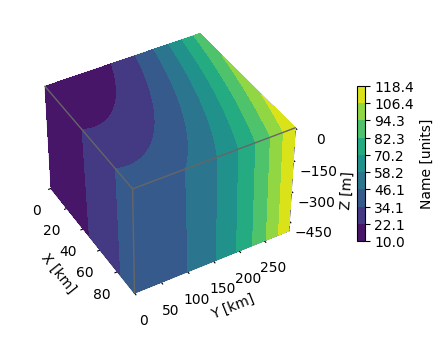

In [3]:
import matplotlib.pyplot as plt
import numpy as np

# Define dimensions
Nx, Ny, Nz = 100, 300, 500
X, Y, Z = np.meshgrid(np.arange(Nx), np.arange(Ny), -np.arange(Nz))

# Create fake data
data = (((X+100)**2 + (Y-20)**2 + 2*Z)/1000+1)

kw = {
    'vmin': data.min(),
    'vmax': data.max(),
    'levels': np.linspace(data.min(), data.max(), 10),
}

# Create a figure with 3D ax
fig = plt.figure(figsize=(5, 4))
ax = fig.add_subplot(111, projection='3d')

# Plot contour surfaces
_ = ax.contourf(
    X[:, :, 0], Y[:, :, 0], data[:, :, 0],
    zdir='z', offset=0, **kw
)
_ = ax.contourf(
    X[0, :, :], data[0, :, :], Z[0, :, :],
    zdir='y', offset=0, **kw
)
C = ax.contourf(
    data[:, -1, :], Y[:, -1, :], Z[:, -1, :],
    zdir='x', offset=X.max(), **kw
)
# --


# Set limits of the plot from coord limits
xmin, xmax = X.min(), X.max()
ymin, ymax = Y.min(), Y.max()
zmin, zmax = Z.min(), Z.max()
ax.set(xlim=[xmin, xmax], ylim=[ymin, ymax], zlim=[zmin, zmax])

# Plot edges
edges_kw = dict(color='0.4', linewidth=1, zorder=1e3)
ax.plot([xmax, xmax], [ymin, ymax], 0, **edges_kw)
ax.plot([xmin, xmax], [ymin, ymin], 0, **edges_kw)
ax.plot([xmax, xmax], [ymin, ymin], [zmin, zmax], **edges_kw)

# Set labels and zticks
ax.set(
    xlabel='X [km]',
    ylabel='Y [km]',
    zlabel='Z [m]',
    zticks=[0, -150, -300, -450],
)

# Set zoom and angle view
ax.view_init(40, -30, 0)
ax.set_box_aspect(None, zoom=0.9)

# Colorbar
fig.colorbar(C, ax=ax, fraction=0.02, pad=0.1, label='Name [units]')

# Show Figure
plt.show()

## Visualizing Layers of Data

In [4]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.colors as mcolors
from tqdm.notebook import tqdm

def visualize3DContourf(filePath, variable="pottmp", 
                        lonRange=(120, 280), latRange=(0, 60),
                        depthIndices=None, depthCount=5, depthStride=1,
                        timeIndex=None, colormap="seismic",
                        alpha=0.5, spacing=0.5, figsize=(12, 6), 
                        rotate=False, frames=32, interval=15, save=False, 
                        filename="rotation.mp4", subtractMean=True, elev=35, azim=-55, ax=None, fig=None, returnColorbar = False):

    with h5py.File(filePath, 'r') as file:
        dataset = file[variable]
        lat = file["lat"][:]
        lon = file["lon"][:]
        depths = file["depth"][:] if "depth" in file else np.arange(dataset.shape[1])
        timeSteps = dataset.shape[0]
        maxDepth = dataset.shape[1] - 1

        lonMask = (lon >= lonRange[0]) & (lon <= lonRange[1])
        latMask = (lat >= latRange[0]) & (lat <= latRange[1])

        if timeIndex is None:
            timeIndex = np.random.randint(0, timeSteps)

        if depthIndices is None:
            depthIndices = np.linspace(0, maxDepth, depthCount, dtype=int)

        depthIndices = np.unique(depthIndices)[::depthStride]

        latSub = lat[latMask]
        lonSub = lon[lonMask]
        lons, lats = np.meshgrid(lonSub, latSub)

        if ax is None:
            fig = plt.figure(figsize=figsize)
            ax = fig.add_subplot(111, projection='3d')

        allValues = []
        depthValues = []

        for i, depth_idx in enumerate(tqdm(depthIndices, desc="Processing Depth Layers", leave=False)):
            slice_data = dataset[timeIndex, depth_idx][np.ix_(latMask, lonMask)]
            slice_data = np.where(np.abs(slice_data) > 1e30, np.nan, slice_data)

            if np.all(np.isnan(slice_data)):
                continue

            if subtractMean:
                validMask = ~np.isnan(slice_data)
                meanVal = np.nanmean(slice_data)
                slice_data[validMask] = slice_data[validMask] - meanVal

            slice_data = np.ma.masked_invalid(slice_data)

            allValues.append(slice_data)
            depthValues.append({
                'depth_value': depths[depth_idx],
                'data': slice_data
            })

        #stacked = np.stack(allValues)
        if allValues:
            stacked = np.stack(allValues)
        else:
            print(f"No data found for configuration")

        vmin = np.nanmin(stacked)
        vmax = np.nanmax(stacked)
        vmean = np.nanmean(stacked)

        norm = mcolors.TwoSlopeNorm(vmin=vmin, vcenter=vmean, vmax=vmax)
        cmap = plt.get_cmap(colormap)

        fadeAlphas = np.linspace(0.05, 0.5, len(depthValues))
        for i, d in enumerate(reversed(depthValues)):
            zs = i * spacing
            maskedData = d['data']

            # 3D contour plot
            ax.contourf(
                lons, lats, maskedData,
                zdir='z', offset=zs,
                levels=20,
                cmap=cmap,
                norm=norm,
                alpha=alpha
            )

            # Overlay black scatter where NaNs exist
            if np.ma.is_masked(maskedData) and np.any(maskedData.mask):
                nanY, nanX = np.where(maskedData.mask)
                nanLon = lonSub[nanX]
                nanLat = latSub[nanY]
                nanZ = np.full_like(nanLon, zs)
                ax.scatter(nanLon, nanLat, nanZ, c='black', s=0.5, alpha=0.25*alpha, marker='s')

            ax.text(lonRange[1], latRange[1], zs, f"{d['depth_value']:.0f}", fontsize=8)

        if fig is not None and len(fig.axes) == 1:
            mappable = cm.ScalarMappable(norm=norm, cmap=cmap)
            mappable.set_array([])
            cbar = fig.colorbar(mappable, ax=ax, pad=0.1, shrink=0.6)
            cbar.set_label(f'{variable.upper()} Value')

        ax.set_xlabel('Longitude')
        ax.set_ylabel('Latitude')
        ax.set_zlabel('Depth Layers')
        ax.set_zticks([])
        ax.set_xlim(lonRange)
        ax.set_ylim(latRange)

        zTop = (len(depthValues) - 1) * spacing
        buffer = spacing * 1.0 if depthStride > 1 else 0.5
        ax.set_zlim(0, zTop + buffer)


        #ax.set_zlim(0, (len(depthValues) - 1) * spacing + 0.5)
        ax.view_init(elev=elev, azim=azim)
        plt.title(f"3D Contourf Visualization of {variable.upper()}\nTime Index: {timeIndex}")
        plt.tight_layout()

        if rotate:
            def update(frame):
                ax.view_init(elev=60, azim=frame)
                return fig,

            ani = animation.FuncAnimation(fig, update, frames=np.linspace(0, 360, frames),
                                          interval=interval, blit=False)

            if save:
                ani.save(filename, fps=1000 // interval, dpi=200)

        if returnColorbar:
            return fig, ax, norm, cmap
        else:
            return fig, ax


In [6]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.colors as mcolors
from tqdm.notebook import tqdm

def visualize3DContourf(filePath, variable="pottmp", 
                        lonRange=(120, 280), latRange=(0, 60),
                        depthIndices=None, depthCount=5, depthStride=1,
                        timeIndex=None, colormap="seismic",
                        alpha=0.5, spacing=0.5, figsize=(12, 6), 
                        rotate=False, frames=32, interval=15, save=False, 
                        filename="rotation.mp4", subtractMean=True, elev=35, azim=-55, ax=None, fig=None, returnColorbar = False):

    with h5py.File(filePath, 'r') as file:
        dataset = file[variable]
        lat = file["lat"][:]
        lon = file["lon"][:]
        depths = file["depth"][:] if "depth" in file else np.arange(dataset.shape[1])
        timeSteps = dataset.shape[0]
        maxDepth = dataset.shape[1] - 1

        lonMask = (lon >= lonRange[0]) & (lon <= lonRange[1])
        latMask = (lat >= latRange[0]) & (lat <= latRange[1])

        if timeIndex is None:
            timeIndex = np.random.randint(0, timeSteps)

        if depthIndices is None:
            depthIndices = np.linspace(0, maxDepth, depthCount, dtype=int)

        depthIndices = np.unique(depthIndices)[::depthStride]

        latSub = lat[latMask]
        lonSub = lon[lonMask]
        lons, lats = np.meshgrid(lonSub, latSub)

        if ax is None:
            fig = plt.figure(figsize=figsize)
            ax = fig.add_subplot(111, projection='3d')

        allValues = []
        depthValues = []

        for i, depth_idx in enumerate(tqdm(depthIndices, desc="Processing Depth Layers", leave=False)):
            slice_data = dataset[timeIndex, depth_idx][np.ix_(latMask, lonMask)]
            slice_data = np.where(np.abs(slice_data) > 1e30, np.nan, slice_data)

            if np.all(np.isnan(slice_data)):
                continue

            if subtractMean:
                validMask = ~np.isnan(slice_data)
                meanVal = np.nanmean(slice_data)
                slice_data[validMask] = slice_data[validMask] - meanVal

            slice_data = np.ma.masked_invalid(slice_data)

            allValues.append(slice_data)
            depthValues.append({
                'depth_value': depths[depth_idx],
                'data': slice_data
            })

        #stacked = np.stack(allValues)
        if allValues:
            stacked = np.stack(allValues)
        else:
            print(f"No data found for configuration")

        vmin = np.nanmin(stacked)
        vmax = np.nanmax(stacked)
        vmean = np.nanmean(stacked)

        norm = mcolors.TwoSlopeNorm(vmin=vmin, vcenter=vmean, vmax=vmax)
        cmap = plt.get_cmap(colormap)

        fadeAlphas = np.linspace(0.05, 0.5, len(depthValues))
        for i, d in enumerate(reversed(depthValues)):
            zs = i * spacing
            maskedData = d['data']

            # 3D contour plot
            ax.contourf(
                lons, lats, maskedData,
                zdir='z', offset=zs,
                levels=20,
                cmap=cmap,
                norm=norm,
                alpha=alpha
            )

            # Overlay black scatter where NaNs exist
            if np.ma.is_masked(maskedData) and np.any(maskedData.mask):
                nanY, nanX = np.where(maskedData.mask)
                nanLon = lonSub[nanX]
                nanLat = latSub[nanY]
                nanZ = np.full_like(nanLon, zs)
                ax.scatter(nanLon, nanLat, nanZ, c='black', s=0.5, alpha=0.25*alpha, marker='s')

            ax.text(lonRange[1], latRange[1], zs, f"{d['depth_value']:.0f}", fontsize=8)

        if fig is not None and len(fig.axes) == 1:
            mappable = cm.ScalarMappable(norm=norm, cmap=cmap)
            mappable.set_array([])
            cbar = fig.colorbar(mappable, ax=ax, pad=0.1, shrink=0.6)
            cbar.set_label(f'{variable.upper()} Value')

        ax.set_xlabel('Longitude')
        ax.set_ylabel('Latitude')
        ax.set_zlabel('Depth Layers')
        ax.set_zticks([])
        ax.set_xlim(lonRange)
        ax.set_ylim(latRange)

        zTop = (len(depthValues) - 1) * spacing
        buffer = spacing * 1.0 if depthStride > 1 else 0.5
        ax.set_zlim(0, zTop + buffer)


        #ax.set_zlim(0, (len(depthValues) - 1) * spacing + 0.5)
        ax.view_init(elev=elev, azim=azim)
        plt.title(f"3D Contourf Visualization of {variable.upper()}\nTime Index: {timeIndex}")
        plt.tight_layout()

        if rotate:
            def update(frame):
                ax.view_init(elev=60, azim=frame)
                return fig,

            ani = animation.FuncAnimation(fig, update, frames=np.linspace(0, 360, frames),
                                          interval=interval, blit=False)

            if save:
                ani.save(filename, fps=1000 // interval, dpi=200)

        if returnColorbar:
            return fig, ax, norm, cmap
        else:
            return fig, ax


Processing Depth Layers:   0%|          | 0/14 [00:00<?, ?it/s]

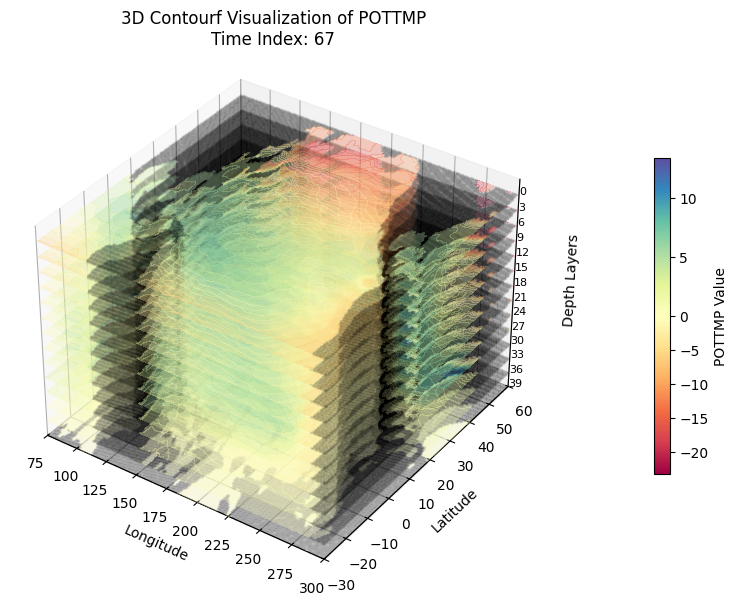

In [7]:
filePath = "/Users/matt/Documents/Machine_Learning_Research/xSlice_Data/XSlice-Climate-Visualization--main/GODAS_data/GODAS_H5_SETS/pottmpMetaData.h5"


fig, ax = visualize3DContourf(
    filePath=filePath,
    variable="pottmp",
    lonRange=(75, 300),
    latRange=(-30, 60),
    depthCount=40,
    depthStride=3,
    spacing=0.0175,
    alpha=0.3,
    colormap="Spectral",
    subtractMean=True,
    rotate=False
)

plt.show()

